In [1]:
import numpy as np 
import astropy.constants as c
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import gc
import math
#list all the constants used
G=c.G.value
M_sun=c.M_sun.value
M_earth=c.M_earth.value
R_sun=c.R_sun.value
R_earth=c.R_earth.value
hour=3600 #s
day=3600*24
e=0.1
t_LC=1765.5 #s

def delta(Rp, Rs):
    delta = (Rp*R_earth / (Rs*R_sun))**2*1e6
    return delta

def SNR(delta,n,sigma_s):
    SNR=delta*n**0.5/sigma_s
    return SNR

def sigma_s(t, sigma_LC, cdppindex): #t/hour
    t_LC=1765.5/hour 

    return sigma_LC*(t/t_LC)**cdppindex

def t_dur(P,Rs,e,a): #hour
    t_dur = P*day*Rs*R_sun*(1-e**2)/(np.pi*a)/hour
    return t_dur

def a(Ms,P):
    a=((G*Ms*M_sun*(P*day)**2)/(4*np.pi**2))**(1/3)
    return a 

def n(t_obs,P): # the unite of t_obs and P is day
    n=t_obs/P
    return n

def f_n(t_obs,P):
    if t_obs <=2*P:
        return 0
    if t_obs> 2*P and t_obs< 3*P:
        return (t_obs/P-2)
    if t_obs>=3*P:
        return 1
    
def f_eff(SNR):
    if SNR <=6:
        return 0
    if SNR >6 and SNR<=12:
        return (SNR-6)/6
    if SNR>12:
        return 1
    
def f_geo(Rp,Rs,a,e):
    f_geo = (Rp*R_earth+Rs*R_sun)/(a*(1-e**2))
    return f_geo

In [2]:
koi_hot=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_hot.csv',sep=',')
koi_cool=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_2sigma_cool.csv',sep=',')

In [5]:
bins=np.logspace(-3,3,30,20)
print(bins)

[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]


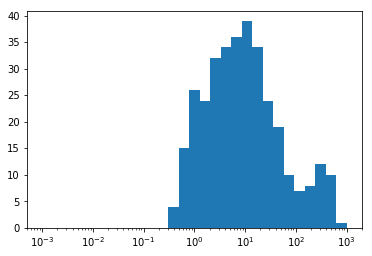

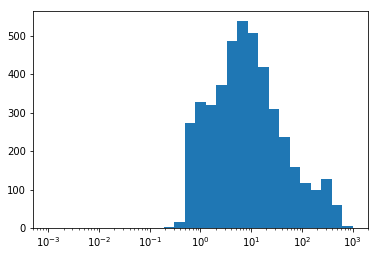

In [8]:
fig=plt.figure()
bins=np.logspace(-3,3,30,20)
plt.hist(koi_hot['koi_period'],bins)
plt.xscale('log')

fig=plt.figure()
plt.hist(koi_cool['koi_period'],bins)
plt.xscale('log')

In [10]:
#exclude the false positive samples and use semi-major axis distribution to show the difference

a_koi_hot=[]
for i in range(0,len(koi_hot)):
    a_koi_hot.append(a(koi_hot['mass'][i],koi_hot['koi_period'][i])/c.au.value)
    
a_koi_cool=[]
for i in range(0,len(koi_cool)):
    a_koi_cool.append(a(koi_cool['mass'][i],koi_cool['koi_period'][i])/c.au.value)
    
    
print(max(a_koi_hot),min(a_koi_hot))
print(max(a_koi_cool),min(a_koi_cool))


1.4769087449895466 0.005879965809567125
2.1520768532612458 0.0065288488977391914


In [17]:
bins=np.logspace(-3,1,20,10)
print(bins)

[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]


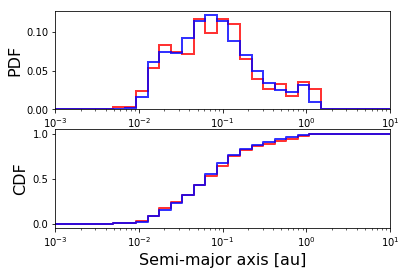

In [27]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(a_koi_hot,a_koi_cool)
plt.figure()
ax1=plt.subplot(2,1,1)
bins=np.logspace(-3,1,30,10)
weights1 = np.ones_like(a_koi_hot)/float(len(a_koi_hot))

ax1.hist(a_koi_hot,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(a_koi_cool)/float(len(a_koi_cool))
ax1.hist(a_koi_cool,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1e-3,10)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(a_koi_hot)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(a_koi_cool)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax2.set_xlabel("Semi-major axis [au]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1e-3,10)
#ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
plt.show()


In [19]:
print(s1)

Ks_2sampResult(statistic=0.03354220219141846, pvalue=0.8696173327917253)


In [22]:
#exclude the false positive samples

a_koi_hot_no_false=[]
for i in range(0,len(koi_hot)):
    if koi_hot['koi_disposition'][i]!='FALSE POSITIVE':
        a_koi_hot_no_false.append(a(koi_hot['mass'][i],koi_hot['koi_period'][i])/c.au.value)
        

a_koi_cool_no_false=[]
for i in range(0,len(koi_cool)):
    if koi_cool['koi_disposition'][i]!='FALSE POSITIVE':
        a_koi_cool_no_false.append(a(koi_cool['mass'][i],koi_cool['koi_period'][i])/c.au.value)
        



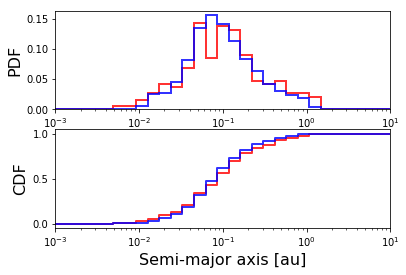

In [26]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(a_koi_hot_no_false,a_koi_cool_no_false)
plt.figure()
ax1=plt.subplot(2,1,1)
bins=np.logspace(-3,1,30,10)
weights1 = np.ones_like(a_koi_hot_no_false)/float(len(a_koi_hot_no_false))

ax1.hist(a_koi_hot_no_false,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(a_koi_cool_no_false)/float(len(a_koi_cool_no_false))
ax1.hist(a_koi_cool_no_false,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1e-3,10)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(a_koi_hot_no_false)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(a_koi_cool_no_false)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax2.set_xlabel("Semi-major axis [au]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1e-3,10)
#ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
plt.show()

In [25]:
print(s1)

Ks_2sampResult(statistic=0.06921166977032905, pvalue=0.35731062527427054)


In [33]:
#exclude the false positive samples

a_koi_hot_no_false_ratio=[] #a/R_star dimensionless
for i in range(0,len(koi_hot)):
    if koi_hot['koi_disposition'][i]!='FALSE POSITIVE':
        a_koi_hot_no_false_ratio.append(a(koi_hot['mass'][i],koi_hot['koi_period'][i])/c.au.value*c.au.value/koi_hot['rad_b2018'][i]/c.R_sun.value)
        

a_koi_cool_no_false_ratio=[]
for i in range(0,len(koi_cool)):
    if koi_cool['koi_disposition'][i]!='FALSE POSITIVE':
        a_koi_cool_no_false_ratio.append(a(koi_cool['mass'][i],koi_cool['koi_period'][i])/c.au.value*c.au.value/koi_cool['rad_b2018'][i]/c.R_sun.value)
        



In [35]:
print(max(a_koi_cool_no_false_ratio),min(a_koi_cool_no_false_ratio))
print(max(a_koi_hot_no_false_ratio),min(a_koi_hot_no_false_ratio))

544.9107942839303 1.0950300665005086
354.4439653847386 3.3327167021452215


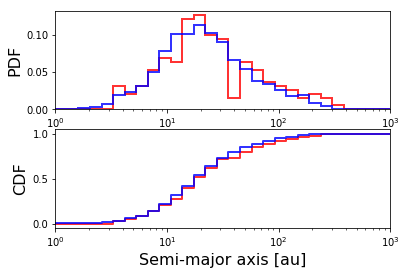

In [38]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(a_koi_hot_no_false_ratio,a_koi_cool_no_false_ratio)
plt.figure()
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,30,10)
weights1 = np.ones_like(a_koi_hot_no_false_ratio)/float(len(a_koi_hot_no_false_ratio))

ax1.hist(a_koi_hot_no_false_ratio,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(a_koi_cool_no_false_ratio)/float(len(a_koi_cool_no_false_ratio))
ax1.hist(a_koi_cool_no_false_ratio,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(a_koi_hot_no_false_ratio)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(a_koi_cool_no_false_ratio)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax2.set_xlabel("Semi-major axis [au]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
#ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
plt.show()

In [39]:
print(s1)

Ks_2sampResult(statistic=0.0816854364340398, pvalue=0.18294643162604465)


In [41]:
#select 3sigma case

#first period

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_p=[]
koi_cool_3sigma_p=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>=3 or koi['sigma_vdec'][i]>=3:
            koi_hot_3sigma_p.append(koi['koi_period'][i])
        else:
            koi_cool_3sigma_p.append(koi['koi_period'][i])

In [44]:
print(koi_hot_3sigma_p)

[1.041619932, 11.931131598, 3.003879547, 17.31711739, 0.93372261, 2.184437698, 153.979362, 1.450889836, 578.88761, 1.257689465, 13.68369259, 17.13263125, 185.97534, 23.81490574, 34.7496038, 15.033062300000005, 6.73808701, 13.0600399, 7.37339245, 5.2433865, 1.33254428, 18.692860599, 472.2265706, 38.103908, 0.971915957, 364.33929, 13.73808249, 198.088873, 385.97241, 7.244778994, 172.70460830000005, 0.5773693360000001, 17.279290765, 0.5667808360000001, 0.54624855, 353.01861, 348.68162, 328.240201, 4.030466786, 37.9456138, 6.47179275, 1.530515205, 18.84497113, 2.56271232, 277.25118]


In [45]:
len(koi_hot_3sigma_p)

45

In [91]:
#select 3sigma case

#first period

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>=2 or koi['sigma_vdec'][i]>=2:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
        else:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)

In [92]:
print(koi_hot_3sigma_a_ratio)

[27.83170860635048, 58.552639412120314, 6.80437123984251, 5.968070839975929, 14.814386469486877, 16.051271842158204, 4.158298825327181, 6.859238177095617, 28.70861906770549, 50.802208910054006, 74.35715361446135, 51.786703545257055, 30.30761924313269, 17.218219269730554, 97.80874606516865, 15.296178490738374, 21.20608391030683, 23.789722208236125, 25.106022892199476, 5.118398936410809, 16.904479489389495, 133.8555586158596, 6.10957142347286, 27.290519891269604, 24.42756079295639, 89.16575119681015, 45.95741363756385, 232.57075504301005, 21.80549272624951, 14.291305936100573, 11.707482256446992, 32.82792104052388, 169.7314584530612, 59.18187022516445, 8.964816109551688, 7.146790951340859, 11.188062868153132, 14.896694728233438, 35.49091465730694, 21.192289569343234, 54.19391962675653, 8.809333615978835, 138.05602620629756, 17.798709101548667, 15.717952152231984, 3.3327167021452215, 56.1025396201621, 5.901649224336938, 4.251907748768508, 14.55697241617736, 61.08362474097583, 84.890568121

In [56]:
print(koi_cool_3sigma_a_ratio)

[101.0279836901812, 8.305312728263694, 19.248613298794467, 25.480856071873745, 67.06771544360633, 28.309120924654735, 4.7860860104549925, 15.522372862623671, 10.229205275102, 34.762503132144765, 247.67765090379717, 79.09515010441977, 9.633825948208614, 35.047176895256605, 14.178748670851856, 35.11542329271753, 65.89262494135447, 23.69668693102311, 7.046285685029721, 17.440309610385874, 13.207106423611034, 22.039797789155127, 90.31535781823546, 7.405794280793349, 8.355770342008581, 16.77553398632553, 87.6927663047097, 79.0457905224267, 40.382736183575716, 9.354391578468414, 90.89836037116287, 378.45944839389216, 4.056184579762301, 13.600407654452766, 17.54137674924912, 15.910314916252618, 10.790845835506454, 67.88042710514527, 48.96502621675131, 13.695149744230168, 22.96731205331761, 50.79414758979145, 32.48527190227134, 177.82341650080036, 25.1515456534319, 36.0971293078293, 26.545393767789704, 20.142895033794762, 280.7901139722638, 56.728901945628046, 131.58952538026162, 23.6805866705

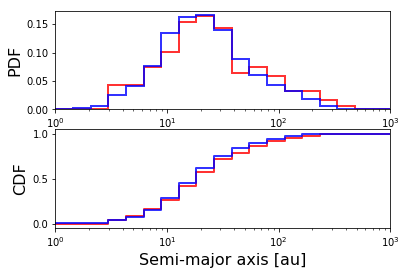

In [93]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio,koi_cool_3sigma_a_ratio)
plt.figure()
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,20,10)
weights1 = np.ones_like(koi_hot_3sigma_a_ratio)/float(len(koi_hot_3sigma_a_ratio))

ax1.hist(koi_hot_3sigma_a_ratio,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_3sigma_a_ratio)/float(len(koi_cool_3sigma_a_ratio))
ax1.hist(koi_cool_3sigma_a_ratio,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax2.set_xlabel("Semi-major axis [au]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
#ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
plt.show()

In [94]:
print(s1)

Ks_2sampResult(statistic=0.0816854364340398, pvalue=0.18294643162604465)


In [125]:
#choose the outermost planet a/R_star to show the difference because the correlation between
#planet period and stellar velocity 

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.5 or koi['sigma_vdec'][i]>2.5:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2.5 and koi['sigma_vdec'][i]<=2.5:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

53 70
1964 2625


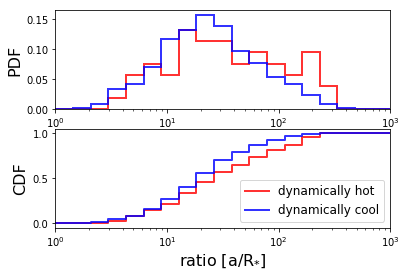

In [126]:
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
plt.figure()
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,20,10)
weights1 = np.ones_like(koi_hot_3sigma_a_ratio_outmost)/float(len(koi_hot_3sigma_a_ratio_outmost))

ax1.hist(koi_hot_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_3sigma_a_ratio_outmost)/float(len(koi_cool_3sigma_a_ratio_outmost))
ax1.hist(koi_cool_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax2.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/ratio.eps")

53 70
1964 2625


Text(0.5, 1.0, 'q=2.5')

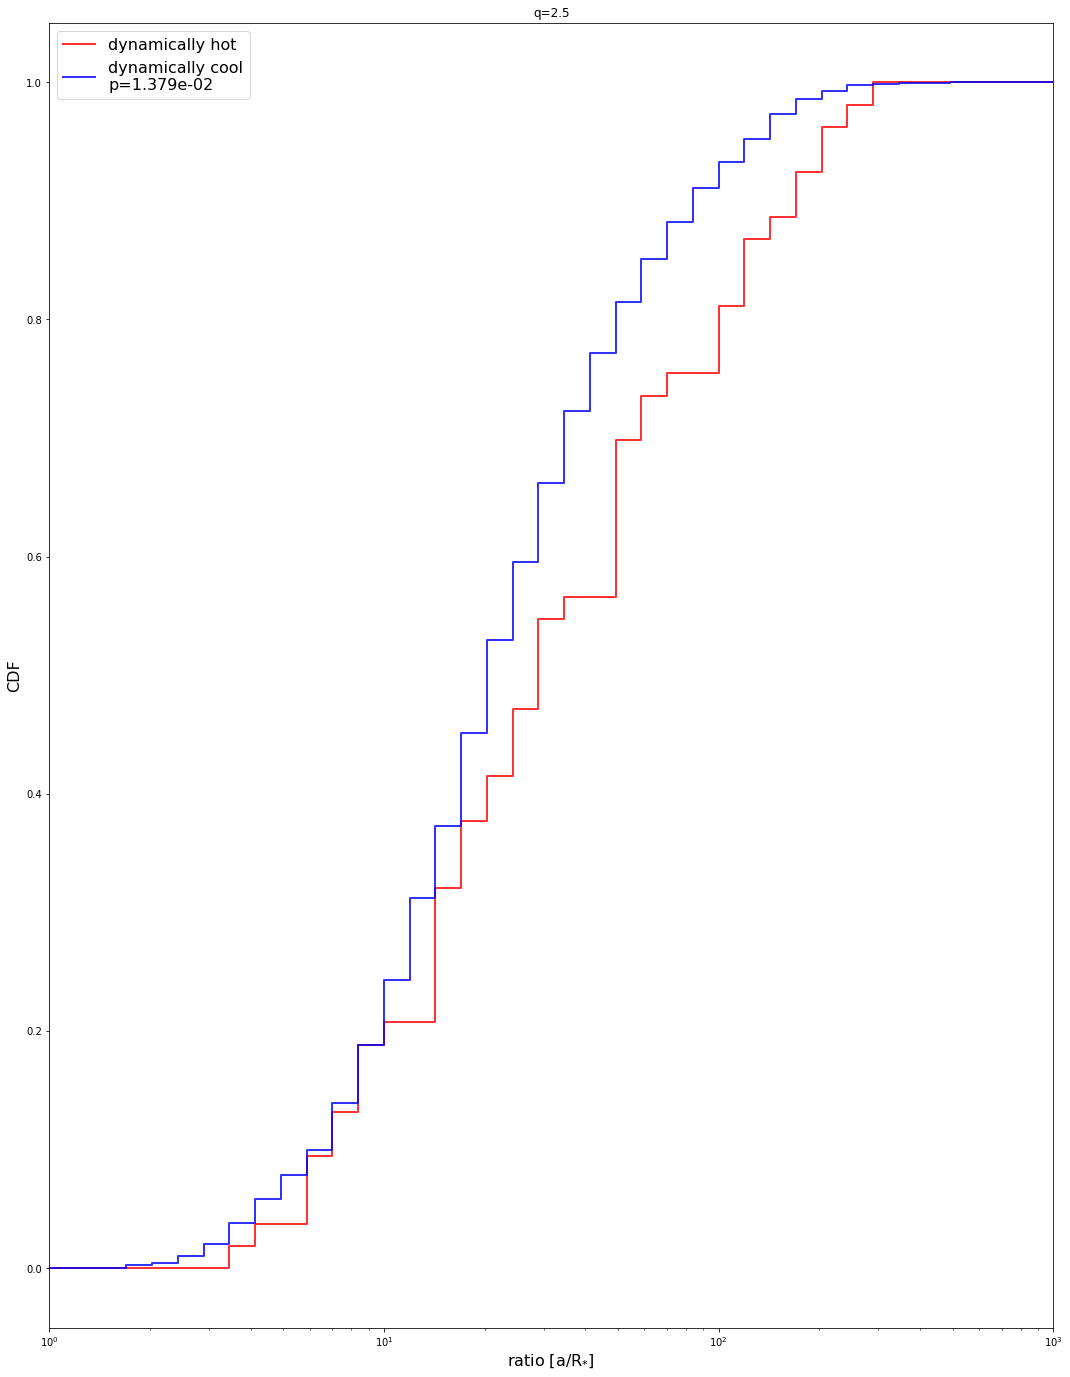

In [130]:
fig=plt.figure(figsize=(18,24))

#q=2.0
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins=np.logspace(0,3,40,10)
koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.5 or koi['sigma_vdec'][i]>2.5:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2.5 and koi['sigma_vdec'][i]<=2.5:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
ax1=plt.subplot(1,1,1)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax1.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax1.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p={:.3e}'.format(s1[1]))
ax1.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax1.set_ylabel("CDF",fontsize=16)
ax1.set_xlim(1,1000)
ax1.legend(loc='best',fontsize=16)
ax1.set_xscale('log')
ax1.set_title('q=2.5')


139 189
1876 2506
117 157
1900 2538
98 132
1919 2563
72 96
1945 2599
61 80
1956 2615


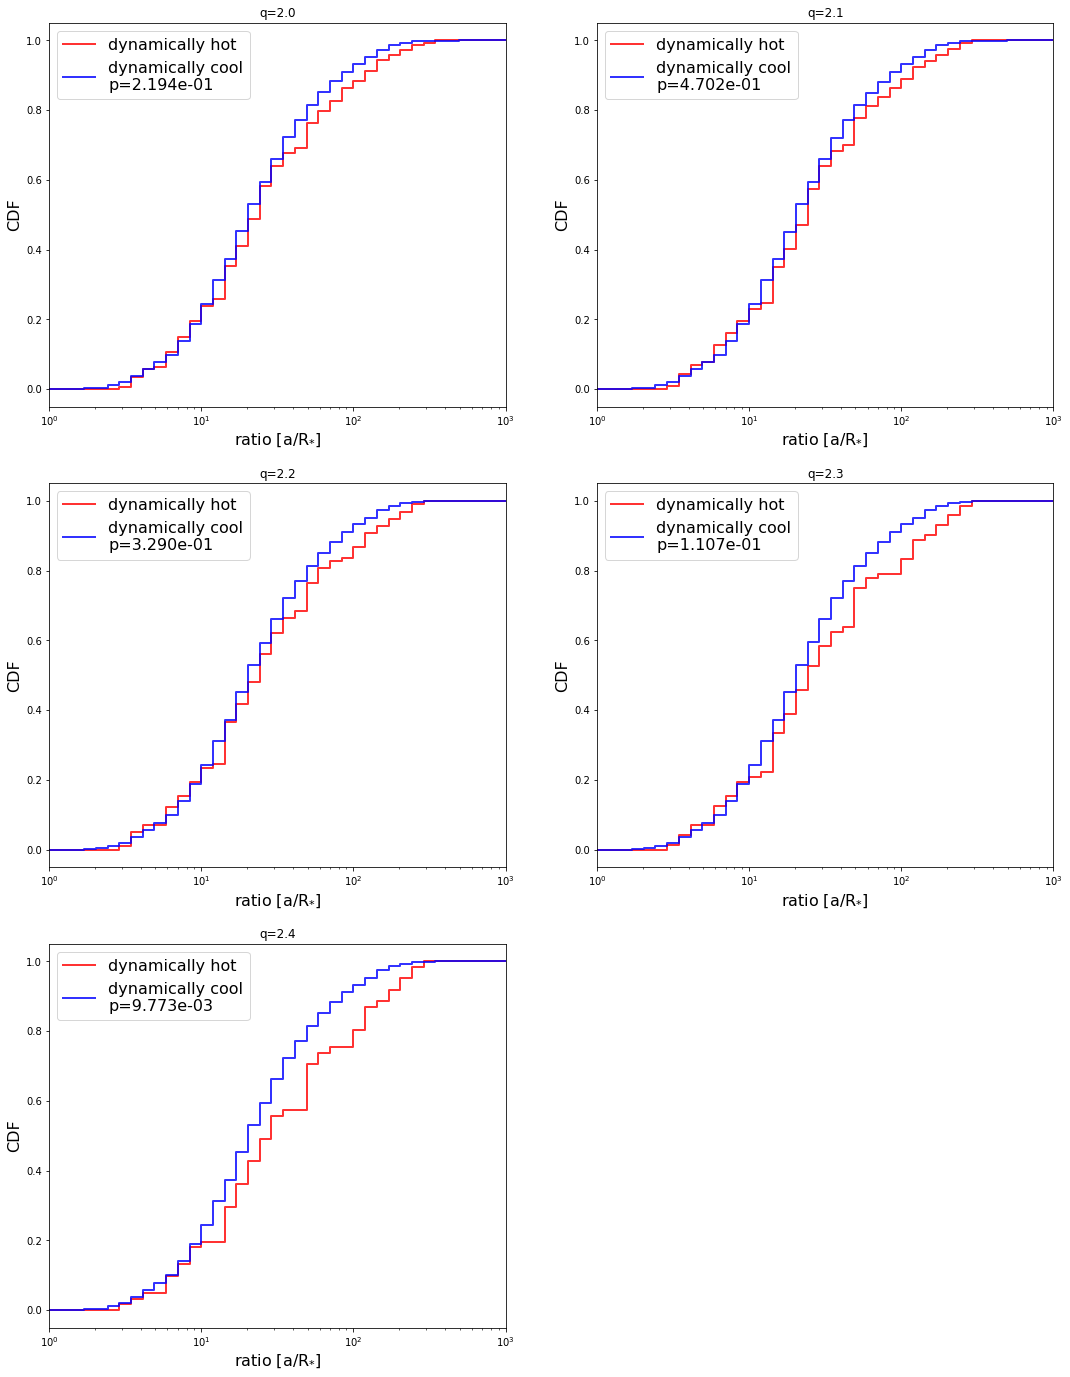

In [129]:
fig=plt.figure(figsize=(18,24))

#q=2.0
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
bins=np.logspace(0,3,40,10)
koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2 or koi['sigma_vdec'][i]>2:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2 and koi['sigma_vdec'][i]<=2:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
ax1=plt.subplot(3,2,1)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax1.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax1.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p={:.3e}'.format(s1[1]))
ax1.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax1.set_ylabel("CDF",fontsize=16)
ax1.set_xlim(1,1000)
ax1.legend(loc='best',fontsize=16)
ax1.set_xscale('log')
ax1.set_title('q=2.0')

#q=2.1
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.1 or koi['sigma_vdec'][i]>2.1:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2.1 and koi['sigma_vdec'][i]<=2.1:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
ax2=plt.subplot(3,2,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:.3e}'.format(s1[1]))
ax2.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
ax2.set_title('q=2.1')

#q=2.2
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.2 or koi['sigma_vdec'][i]>2.2:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2.2 and koi['sigma_vdec'][i]<=2.2:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
ax3=plt.subplot(3,2,3)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax3.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax3.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:.3e}'.format(s1[1]))
ax3.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax3.set_ylabel("CDF",fontsize=16)
ax3.set_xlim(1,1000)
ax3.legend(loc='best',fontsize=16)
ax3.set_xscale('log')
ax3.set_title('q=2.2')

#q=2.3
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.3 or koi['sigma_vdec'][i]>2.3:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2.3 and koi['sigma_vdec'][i]<=2.3:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
ax4=plt.subplot(3,2,4)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax4.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax4.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:.3e}'.format(s1[1]))
ax4.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax4.set_ylabel("CDF",fontsize=16)
ax4.set_xlim(1,1000)
ax4.legend(loc='best',fontsize=16)
ax4.set_xscale('log')
ax4.set_title('q=2.3')

#q=2.4
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]
id_hot=[]
id_cool=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.4 or koi['sigma_vdec'][i]>2.4:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
        elif koi['sigma_vra'][i]<=2.4 and koi['sigma_vdec'][i]<=2.4:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])

koi_hot_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
ax5=plt.subplot(3,2,5)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax5.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax5.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:.3e}'.format(s1[1]))
ax5.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax5.set_ylabel("CDF",fontsize=16)
ax5.set_xlim(1,1000)
ax5.legend(loc='best',fontsize=16)
ax5.set_xscale('log')
ax5.set_title('q=2.4')

plt.savefig("result/differece_q_a_ratio.eps")

0.9845212786271917 544.9107942839303


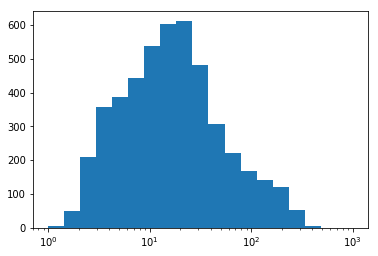

In [85]:
#the stars with different period have difference velocity distribution?



koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')
a_ratio=[]


for i in range(0,len(koi)):
    a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)

bins=np.logspace(0,3,20,10)
plt.hist(a_ratio,bins)
plt.xscale('log')
print(min(a_ratio),max(a_ratio))
'''
sigma_vra_shortp=[]
sigma_vdec_shortp=[]
sigma_vra_largep=[]
sigma_vdec_largep=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['koi_period'][i]<=1:
            sigma_vra_shortp.append(koi['sigma_vra'][i])
            sigma_vdec_shortp.append(koi['sigma_vdec'][i])
        if koi['koi_period'][i]>=100:
            sigma_vra_largep.append(koi['sigma_vra'][i])
            sigma_vdec_largep.append(koi['sigma_vdec'][i])
'''     
sigma_vra_shortp=[]
sigma_vdec_shortp=[]
sigma_vra_largep=[]
sigma_vdec_largep=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if a_ratio[i]<=3:
            sigma_vra_shortp.append(koi['sigma_vra'][i])
            sigma_vdec_shortp.append(koi['sigma_vdec'][i])
        if a_ratio[i]>=200:
            sigma_vra_largep.append(koi['sigma_vra'][i])
            sigma_vdec_largep.append(koi['sigma_vdec'][i])



In [86]:
print(max(sigma_vra_shortp),max(sigma_vdec_shortp))
print(min(sigma_vra_shortp),min(sigma_vdec_shortp))
print(max(sigma_vra_largep),max(sigma_vdec_largep))
print(min(sigma_vra_largep),min(sigma_vdec_largep))

1.5149103136314668 1.4026600185578555
0.17955655181203764 0.011572863083415787
3.2521039324162047 3.023606620418404
0.049369672434841416 0.013900547761195058


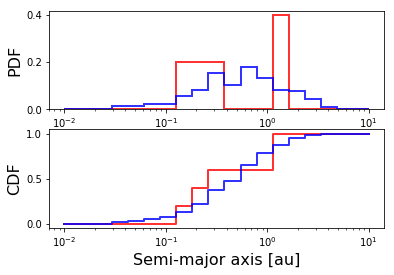

In [83]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(sigma_vra_shortp,sigma_vra_largep)
plt.figure()
ax1=plt.subplot(2,1,1)
bins=np.logspace(-2,1,20,10)
weights1 = np.ones_like(sigma_vra_shortp)/float(len(sigma_vra_shortp))

ax1.hist(sigma_vra_shortp,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(sigma_vra_largep)/float(len(sigma_vra_largep))
ax1.hist(sigma_vra_largep,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(sigma_vra_shortp)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#+'p='+'{:5f}'.format(s1[1]))
ecdf=sm.distributions.ECDF(sigma_vra_largep)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
ax2.set_xlabel("Semi-major axis [au]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
#ax2.legend(loc='best',fontsize=16)
ax2.set_xscale('log')
plt.show()

57 76
1929 2584


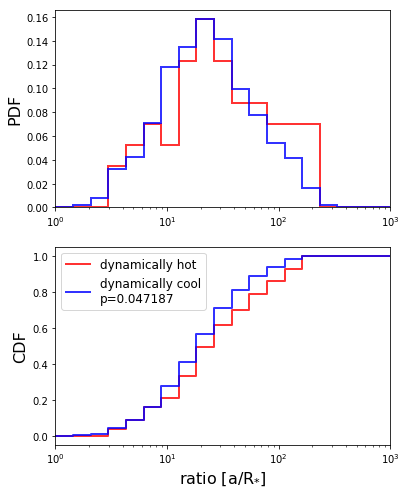

In [3]:
#choose the outermost planet a/R_star to show the difference because the correlation between
#planet period and stellar velocity 

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]

id_hot=[]
id_cool=[]

koi_hot_feh=[]
koi_cool_feh=[]

koi_hot_mass=[]
koi_cool_mass=[]

koi_hot_teff=[]
koi_cool_teff=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE' and koi['koi_period'][i]<365:
        if koi['sigma_vra'][i]>2.4 or koi['sigma_vdec'][i]>2.4:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
            koi_hot_feh.append(koi['feh'][i])
            koi_hot_mass.append(koi['mass'][i])
            koi_hot_teff.append(koi['teff_b2018'][i])
        elif koi['sigma_vra'][i]<=2.4 and koi['sigma_vdec'][i]<=2.4:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])
            koi_cool_feh.append(koi['feh'][i])
            koi_cool_mass.append(koi['mass'][i])
            koi_cool_teff.append(koi['teff_b2018'][i])

koi_hot_3sigma_a_ratio_outmost=[]
koi_hot_host_feh=[]
koi_hot_host_mass=[]
koi_hot_host_teff=[]
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_hot_host_feh.append(koi_hot_feh[i])
    koi_hot_host_mass.append(koi_hot_mass[i])
    koi_hot_host_teff.append(koi_hot_teff[i])
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
koi_cool_host_feh=[]
koi_cool_host_mass=[]
koi_cool_host_teff=[]

i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_cool_host_feh.append(koi_cool_feh[i])
    koi_cool_host_mass.append(koi_cool_mass[i])
    koi_cool_host_teff.append(koi_cool_teff[i])
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,20,10)
weights1 = np.ones_like(koi_hot_3sigma_a_ratio_outmost)/float(len(koi_hot_3sigma_a_ratio_outmost))

ax1.hist(koi_hot_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_3sigma_a_ratio_outmost)/float(len(koi_cool_3sigma_a_ratio_outmost))
ax1.hist(koi_cool_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/ratio.eps")

In [140]:
print(np.max(koi_hot_host_feh),np.min(koi_hot_host_feh))
print(np.max(koi_cool_host_feh),np.min(koi_cool_host_feh))

0.32 -1.7
0.56 -1.46


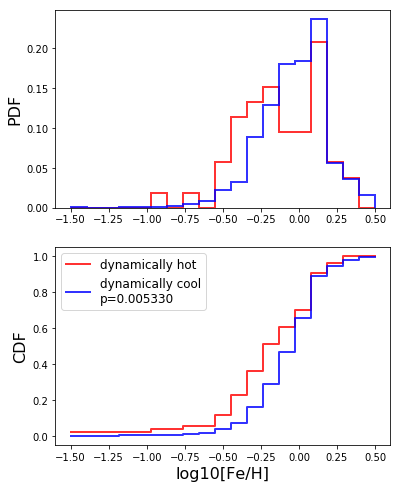

In [145]:
#show the difference of distribution of stellar properties for different stellar velocity.

#first stellar metallicity
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_host_feh,koi_cool_host_feh)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(-1.5,0.5,20)
weights1 = np.ones_like(koi_hot_host_feh)/float(len(koi_hot_host_feh))

ax1.hist(koi_hot_host_feh,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_host_feh)/float(len(koi_cool_host_feh))
ax1.hist(koi_cool_host_feh,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_host_feh)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_host_feh)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("log10[Fe/H]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/q2dot5_feh.eps")

In [146]:
print(np.max(koi_hot_host_mass),np.min(koi_hot_host_mass))
print(np.max(koi_cool_host_mass),np.min(koi_cool_host_mass))

2.049 0.10099999999999999
3.573 0.132


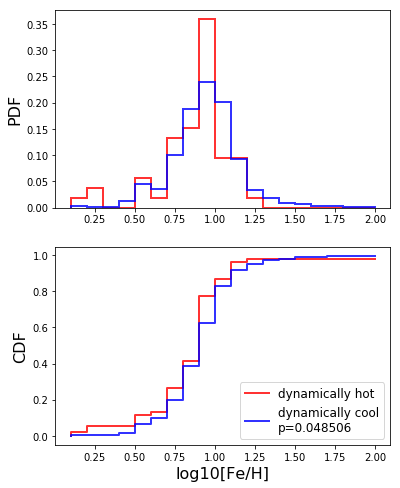

In [161]:
#show the difference of distribution of stellar properties for different stellar velocity.

#first stellar mass
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_host_mass,koi_cool_host_mass)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(0.1,2,20)
weights1 = np.ones_like(koi_hot_host_mass)/float(len(koi_hot_host_mass))

ax1.hist(koi_hot_host_mass,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_host_mass)/float(len(koi_cool_host_mass))
ax1.hist(koi_cool_host_mass,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xlim(0.1,0.7)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_host_mass)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_host_mass)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("M$_{*}$ [M$_{\odot}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/q2dot5_mass.eps")

In [162]:
print(np.max(koi_hot_host_teff),np.min(koi_hot_host_teff))
print(np.max(koi_cool_host_teff),np.min(koi_cool_host_teff))

7359.0 3325.0
9578.0 3157.0


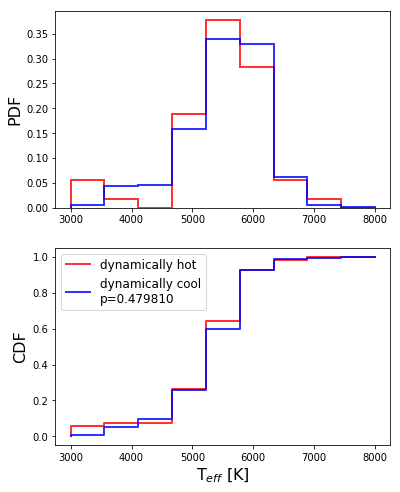

In [164]:
#show the difference of distribution of stellar properties for different stellar velocity.

#first stellar Teff
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_host_teff,koi_cool_host_teff)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(3000,8000,10)
weights1 = np.ones_like(koi_hot_host_teff)/float(len(koi_hot_host_teff))

ax1.hist(koi_hot_host_teff,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_host_teff)/float(len(koi_cool_host_teff))
ax1.hist(koi_cool_host_teff,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xlim(0.1,0.7)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_host_teff)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_host_teff)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("T$_{eff}$ [K]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/q2dot5_teff.eps")

53 70
1964 2625


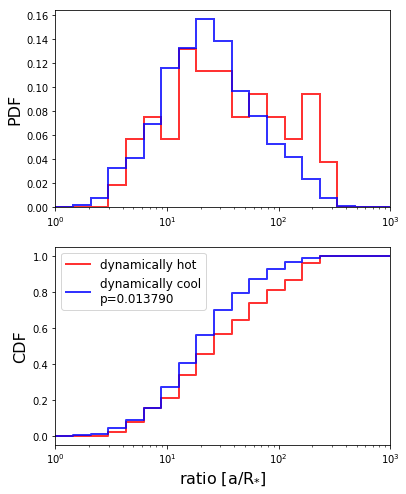

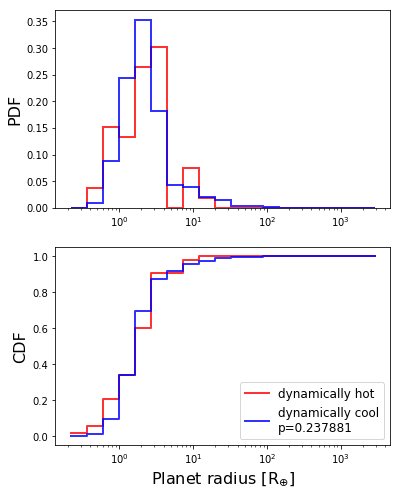

In [4]:
#choose the outermost planet a/R_star to show the difference because the correlation between
#planet period and stellar velocity 

#largest Period distribution
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]

id_hot=[]
id_cool=[]

koi_hot_feh=[]
koi_cool_feh=[]

koi_hot_mass=[]
koi_cool_mass=[]

koi_hot_teff=[]
koi_cool_teff=[]

koi_hot_p=[]
koi_cool_p=[]

koi_hot_rp=[]
koi_cool_rp=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.5 or koi['sigma_vdec'][i]>2.5:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            koi_hot_p.append(koi['koi_period'][i])
            koi_hot_rp.append(koi['koi_prad'][i])
            id_hot.append(koi['kepid'][i])
            koi_hot_feh.append(koi['feh'][i])
            koi_hot_mass.append(koi['mass'][i])
            koi_hot_teff.append(koi['teff_b2018'][i])
        elif koi['sigma_vra'][i]<=2.5 and koi['sigma_vdec'][i]<=2.5:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            koi_cool_p.append(koi['koi_period'][i])
            koi_cool_rp.append(koi['koi_prad'][i])
            id_cool.append(koi['kepid'][i])
            koi_cool_feh.append(koi['feh'][i])
            koi_cool_mass.append(koi['mass'][i])
            koi_cool_teff.append(koi['teff_b2018'][i])

koi_hot_3sigma_a_ratio_outmost=[]
koi_hot_host_feh=[]
koi_hot_host_mass=[]
koi_hot_host_teff=[]
koi_hot_p_largest=[]
koi_hot_rp_largest=[]
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    p_temp=[]
    p_temp.append(koi_hot_p[i])
    rp_temp=[]
    rp_temp.append(koi_hot_rp[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            p_temp.append(koi_hot_p[j])
            rp_temp.append(koi_hot_rp[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_hot_p_largest.append(max(p_temp))
    koi_hot_rp_largest.append(rp_temp[int(a_ratio_temp.index(max(a_ratio_temp)))])
    koi_hot_host_feh.append(koi_hot_feh[i])
    koi_hot_host_mass.append(koi_hot_mass[i])
    koi_hot_host_teff.append(koi_hot_teff[i])
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
koi_cool_host_feh=[]
koi_cool_host_mass=[]
koi_cool_host_teff=[]
koi_cool_p_largest=[]
koi_cool_rp_largest=[]
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    p_temp=[]
    p_temp.append(koi_cool_p[i])
    rp_temp=[]
    rp_temp.append(koi_cool_rp[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            p_temp.append(koi_cool_p[j])
            rp_temp.append(koi_cool_rp[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_cool_rp_largest.append(rp_temp[int(a_ratio_temp.index(max(a_ratio_temp)))])
    koi_cool_p_largest.append(max(p_temp))
    koi_cool_host_feh.append(koi_cool_feh[i])
    koi_cool_host_mass.append(koi_cool_mass[i])
    koi_cool_host_teff.append(koi_cool_teff[i])
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,20,10)
weights1 = np.ones_like(koi_hot_3sigma_a_ratio_outmost)/float(len(koi_hot_3sigma_a_ratio_outmost))

ax1.hist(koi_hot_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_3sigma_a_ratio_outmost)/float(len(koi_cool_3sigma_a_ratio_outmost))
ax1.hist(koi_cool_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/ratio.eps")


#rp distribution
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_rp_largest,koi_cool_rp_largest)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(np.log10(min(koi['koi_prad'])),np.log10(max(koi['koi_prad'])),20,10)
weights1 = np.ones_like(koi_hot_rp_largest)/float(len(koi_hot_rp_largest))

ax1.hist(koi_hot_rp_largest,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_rp_largest)/float(len(koi_cool_rp_largest))
ax1.hist(koi_cool_rp_largest,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_rp_largest)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_rp_largest)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("Planet radius [R$_{\oplus}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/rp.eps")



In [166]:
print(np.max(koi_hot_p_largest),np.min(koi_hot_p_largest))
print(np.max(koi_cool_p_largest),np.min(koi_cool_p_largest))

578.88761 0.5773693360000001
1071.232624 0.259819659


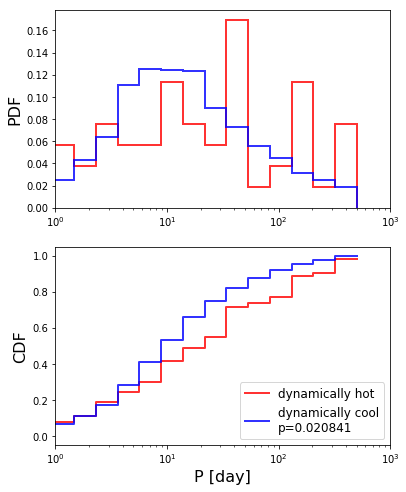

In [170]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_p_largest,koi_cool_p_largest)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(-1,2.7,20,10)
weights1 = np.ones_like(koi_hot_p_largest)/float(len(koi_hot_p_largest))

ax1.hist(koi_hot_p_largest,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_p_largest)/float(len(koi_cool_p_largest))
ax1.hist(koi_cool_p_largest,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_p_largest)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_p_largest)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("P [day]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/p_largest.eps")

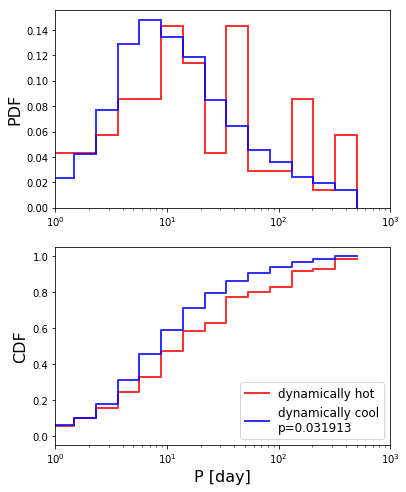

In [171]:
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_p,koi_cool_p)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(np.log10(min()),2.7,20,10)
weights1 = np.ones_like(koi_hot_p)/float(len(koi_hot_p))

ax1.hist(koi_hot_p,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_p)/float(len(koi_cool_p))
ax1.hist(koi_cool_p,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_p)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_p)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("P [day]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/p.eps")

In [4]:
#draw the vetting efficiency and detection efficiency of the KOI 

#second calculate detection efficiency

f_det_hot=[]
f_det_cool=[]

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]

id_hot=[]
id_cool=[]

koi_hot_feh=[]
koi_cool_feh=[]

koi_hot_mass=[]
koi_cool_mass=[]

koi_hot_teff=[]
koi_cool_teff=[]

koi_hot_p=[]
koi_cool_p=[]

koi_hot_rp=[]
koi_cool_rp=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.5 or koi['sigma_vdec'][i]>2.5:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            koi_hot_p.append(koi['koi_period'][i])
            koi_hot_rp.append(koi['koi_prad'][i])
            id_hot.append(koi['kepid'][i])
            koi_hot_feh.append(koi['feh'][i])
            koi_hot_mass.append(koi['mass'][i])
            koi_hot_teff.append(koi['teff_b2018'][i])
            f_det_hot.append(f_eff(koi['koi_model_snr'][i]))
        elif koi['sigma_vra'][i]<=2.5 and koi['sigma_vdec'][i]<=2.5:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            koi_cool_p.append(koi['koi_period'][i])
            koi_cool_rp.append(koi['koi_prad'][i])
            id_cool.append(koi['kepid'][i])
            koi_cool_feh.append(koi['feh'][i])
            koi_cool_mass.append(koi['mass'][i])
            koi_cool_teff.append(koi['teff_b2018'][i])
            f_det_cool.append(f_eff(koi['koi_model_snr'][i]))

koi_hot_3sigma_a_ratio_outmost=[]
koi_hot_host_feh=[]
koi_hot_host_mass=[]
koi_hot_host_teff=[]
koi_hot_p_largest=[]
koi_hot_rp_largest=[]
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    p_temp=[]
    p_temp.append(koi_hot_p[i])
    rp_temp=[]
    rp_temp.append(koi_hot_rp[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            p_temp.append(koi_hot_p[j])
            rp_temp.append(koi_hot_rp[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_hot_p_largest.append(max(p_temp))
    koi_hot_rp_largest.append(rp_temp[int(a_ratio_temp.index(max(a_ratio_temp)))])
    koi_hot_host_feh.append(koi_hot_feh[i])
    koi_hot_host_mass.append(koi_hot_mass[i])
    koi_hot_host_teff.append(koi_hot_teff[i])
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
koi_cool_host_feh=[]
koi_cool_host_mass=[]
koi_cool_host_teff=[]
koi_cool_p_largest=[]
koi_cool_rp_largest=[]
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    p_temp=[]
    p_temp.append(koi_cool_p[i])
    rp_temp=[]
    rp_temp.append(koi_cool_rp[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            p_temp.append(koi_cool_p[j])
            rp_temp.append(koi_cool_rp[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_cool_rp_largest.append(rp_temp[int(a_ratio_temp.index(max(a_ratio_temp)))])
    koi_cool_p_largest.append(max(p_temp))
    koi_cool_host_feh.append(koi_cool_feh[i])
    koi_cool_host_mass.append(koi_cool_mass[i])
    koi_cool_host_teff.append(koi_cool_teff[i])
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))


53 70
1964 2625


In [5]:
print(max(f_det_hot),min(f_det_hot))
print(max(f_det_cool),min(f_det_cool))

1 0
1 0


In [6]:
f_det_cool

[0.21666666666666665,
 1,
 1,
 1,
 1,
 0.9333333333333332,
 1,
 0.5166666666666666,
 1,
 0.9333333333333332,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.75,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.85,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.8833333333333334,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.8166666666666668,
 0.4333333333333333,
 1,
 0,
 0.3,
 1,
 1,
 0.8166666666666668,
 1,
 0.2833333333333334,
 1,
 1,
 1,
 1.0,
 1,
 1,
 0.9833333333333334,
 1,
 0.65,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.8666666666666666,
 1,
 1,
 1,
 1,
 1,
 0.5,
 1,
 1,
 1,
 1,
 1,
 0.7666666666666666,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.4499999999999999,
 1,
 1,
 0.5,
 1,
 1,
 0.6833333333333332,
 1,
 1,
 1,
 1,
 1,
 0.65,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.6333333333333334,
 1,
 1,
 1,
 1,
 1,
 0.5166666666666666,
 0.8666666666666666,
 1,
 1,
 0.6,
 1,
 1,
 1,
 0.3499999999999999,
 1,
 1,
 0.9166

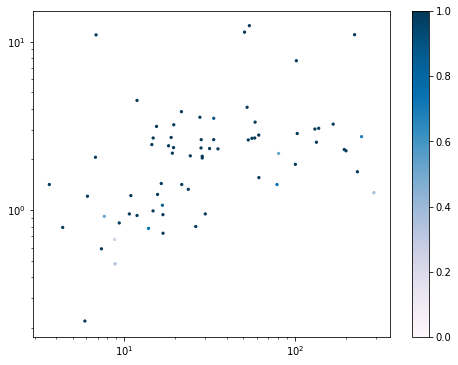

In [21]:
fig=plt.figure(figsize=(8,6))
ax0=fig.add_subplot(111)
c0=ax0.scatter(koi_hot_3sigma_a_ratio,koi_hot_rp,c=f_det_hot,s=5,vmin=0,vmax=1,cmap='PuBu')
#c1=ax0.scatter(koi_cool_3sigma_a_ratio,koi_cool_rp,c=f_det_cool,s=5,vmin=0,vmax=1,cmap='PuBu')
fig.colorbar(c0,ax=ax0)
ax0.set_xscale('log')
ax0.set_yscale('log')

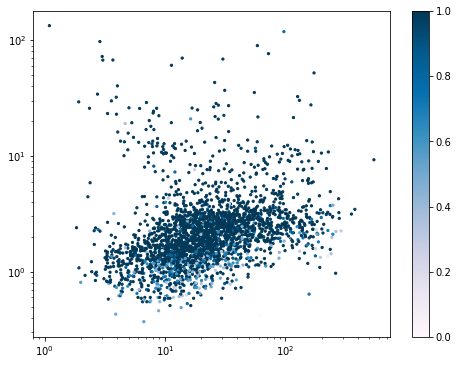

In [22]:
fig=plt.figure(figsize=(8,6))
ax0=fig.add_subplot(111)
#c0=ax0.scatter(koi_hot_3sigma_a_ratio,koi_hot_rp,c=f_det_hot,s=5,vmin=0,vmax=1,cmap='PuBu')
c1=ax0.scatter(koi_cool_3sigma_a_ratio,koi_cool_rp,c=f_det_cool,s=5,vmin=0,vmax=1,cmap='PuBu')
fig.colorbar(c0,ax=ax0)
ax0.set_xscale('log')
ax0.set_yscale('log')

In [24]:
#second calculate vetting efficiency

f_vet_hot=[]
f_vet_cool=[]

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]

id_hot=[]
id_cool=[]

koi_hot_feh=[]
koi_cool_feh=[]

koi_hot_mass=[]
koi_cool_mass=[]

koi_hot_teff=[]
koi_cool_teff=[]

koi_hot_p=[]
koi_cool_p=[]

koi_hot_rp=[]
koi_cool_rp=[]
t_obs=1415 #assume that every star observation time = 1415 day
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>2.5 or koi['sigma_vdec'][i]>2.5:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            koi_hot_p.append(koi['koi_period'][i])
            koi_hot_rp.append(koi['koi_prad'][i])
            id_hot.append(koi['kepid'][i])
            koi_hot_feh.append(koi['feh'][i])
            koi_hot_mass.append(koi['mass'][i])
            koi_hot_teff.append(koi['teff_b2018'][i])
            f_vet_hot.append(f_n(t_obs,koi['koi_period'][i]))
        elif koi['sigma_vra'][i]<=2.5 and koi['sigma_vdec'][i]<=2.5:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            koi_cool_p.append(koi['koi_period'][i])
            koi_cool_rp.append(koi['koi_prad'][i])
            id_cool.append(koi['kepid'][i])
            koi_cool_feh.append(koi['feh'][i])
            koi_cool_mass.append(koi['mass'][i])
            koi_cool_teff.append(koi['teff_b2018'][i])
            f_vet_cool.append(f_n(t_obs,koi['koi_period'][i]))

koi_hot_3sigma_a_ratio_outmost=[]
koi_hot_host_feh=[]
koi_hot_host_mass=[]
koi_hot_host_teff=[]
koi_hot_p_largest=[]
koi_hot_rp_largest=[]
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    p_temp=[]
    p_temp.append(koi_hot_p[i])
    rp_temp=[]
    rp_temp.append(koi_hot_rp[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            p_temp.append(koi_hot_p[j])
            rp_temp.append(koi_hot_rp[j])
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_hot_p_largest.append(max(p_temp))
    koi_hot_rp_largest.append(rp_temp[int(a_ratio_temp.index(max(a_ratio_temp)))])
    koi_hot_host_feh.append(koi_hot_feh[i])
    koi_hot_host_mass.append(koi_hot_mass[i])
    koi_hot_host_teff.append(koi_hot_teff[i])
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
koi_cool_host_feh=[]
koi_cool_host_mass=[]
koi_cool_host_teff=[]
koi_cool_p_largest=[]
koi_cool_rp_largest=[]
i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    p_temp=[]
    p_temp.append(koi_cool_p[i])
    rp_temp=[]
    rp_temp.append(koi_cool_rp[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            p_temp.append(koi_cool_p[j])
            rp_temp.append(koi_cool_rp[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_cool_rp_largest.append(rp_temp[int(a_ratio_temp.index(max(a_ratio_temp)))])
    koi_cool_p_largest.append(max(p_temp))
    koi_cool_host_feh.append(koi_cool_feh[i])
    koi_cool_host_mass.append(koi_cool_mass[i])
    koi_cool_host_teff.append(koi_cool_teff[i])
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))


53 70
1964 2625


In [26]:
f_vet_cool,


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.7994140721492613,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,

20 24
1995 2671


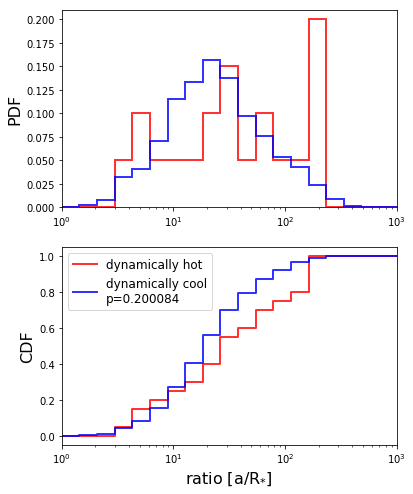

In [29]:
#choose the outermost planet a/R_star to show the difference because the correlation between
#planet period and stellar velocity 

#q=3
koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]

id_hot=[]
id_cool=[]

koi_hot_feh=[]
koi_cool_feh=[]

koi_hot_mass=[]
koi_cool_mass=[]

koi_hot_teff=[]
koi_cool_teff=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE':
        if koi['sigma_vra'][i]>3 or koi['sigma_vdec'][i]>3:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
            koi_hot_feh.append(koi['feh'][i])
            koi_hot_mass.append(koi['mass'][i])
            koi_hot_teff.append(koi['teff_b2018'][i])
        elif koi['sigma_vra'][i]<=3 and koi['sigma_vdec'][i]<=3:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])
            koi_cool_feh.append(koi['feh'][i])
            koi_cool_mass.append(koi['mass'][i])
            koi_cool_teff.append(koi['teff_b2018'][i])

koi_hot_3sigma_a_ratio_outmost=[]
koi_hot_host_feh=[]
koi_hot_host_mass=[]
koi_hot_host_teff=[]
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_hot_host_feh.append(koi_hot_feh[i])
    koi_hot_host_mass.append(koi_hot_mass[i])
    koi_hot_host_teff.append(koi_hot_teff[i])
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
koi_cool_host_feh=[]
koi_cool_host_mass=[]
koi_cool_host_teff=[]

i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_cool_host_feh.append(koi_cool_feh[i])
    koi_cool_host_mass.append(koi_cool_mass[i])
    koi_cool_host_teff.append(koi_cool_teff[i])
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,20,10)
weights1 = np.ones_like(koi_hot_3sigma_a_ratio_outmost)/float(len(koi_hot_3sigma_a_ratio_outmost))

ax1.hist(koi_hot_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_3sigma_a_ratio_outmost)/float(len(koi_cool_3sigma_a_ratio_outmost))
ax1.hist(koi_cool_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/q3_ratio.eps")

100 136
1460 1947


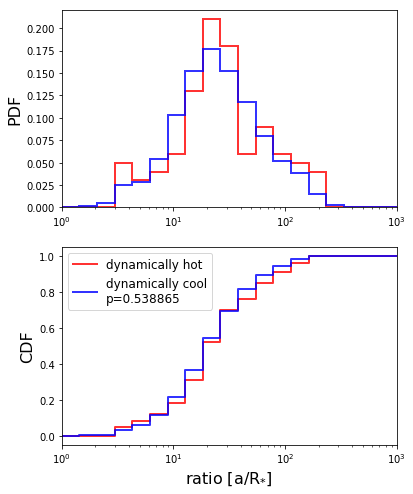

In [8]:
#choose the outermost planet a/R_star to show the difference because the correlation between
#planet period and stellar velocity 

koi=pd.read_csv('data/kepler_koi_q17_add_dispersions_reduction_reduction_new.csv',sep=',')

koi_hot_3sigma_a_ratio=[]
koi_cool_3sigma_a_ratio=[]

id_hot=[]
id_cool=[]

koi_hot_feh=[]
koi_cool_feh=[]

koi_hot_mass=[]
koi_cool_mass=[]

koi_hot_teff=[]
koi_cool_teff=[]
for i in range(0,len(koi)):
    if koi['koi_disposition'][i]!='FALSE POSITIVE' and koi['koi_period'][i]<365 and koi['koi_prad'][i]<=4 and koi['koi_prad'][i]>=1:
        if koi['sigma_vra'][i]>2 or koi['sigma_vdec'][i]>2:
            koi_hot_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_hot.append(koi['kepid'][i])
            koi_hot_feh.append(koi['feh'][i])
            koi_hot_mass.append(koi['mass'][i])
            koi_hot_teff.append(koi['teff_b2018'][i])
        elif koi['sigma_vra'][i]<=2 and koi['sigma_vdec'][i]<=2:
            koi_cool_3sigma_a_ratio.append(a(koi['mass'][i],koi['koi_period'][i])/c.au.value*c.au.value/koi['rad_b2018'][i]/c.R_sun.value)
            id_cool.append(koi['kepid'][i])
            koi_cool_feh.append(koi['feh'][i])
            koi_cool_mass.append(koi['mass'][i])
            koi_cool_teff.append(koi['teff_b2018'][i])

koi_hot_3sigma_a_ratio_outmost=[]
koi_hot_host_feh=[]
koi_hot_host_mass=[]
koi_hot_host_teff=[]
i=0
while i<len(id_hot)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_hot_3sigma_a_ratio[i])
    for j in range(i+1,len(id_hot)):
        if id_hot[i]==id_hot[j]:
            a_ratio_temp.append(koi_hot_3sigma_a_ratio[j])
            
            
        else:
            i=j-1
            break
    koi_hot_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_hot_host_feh.append(koi_hot_feh[i])
    koi_hot_host_mass.append(koi_hot_mass[i])
    koi_hot_host_teff.append(koi_hot_teff[i])
    i+=1

koi_cool_3sigma_a_ratio_outmost=[] 
koi_cool_host_feh=[]
koi_cool_host_mass=[]
koi_cool_host_teff=[]

i=0
while i<len(id_cool)-1:
    a_ratio_temp=[]
    a_ratio_temp.append(koi_cool_3sigma_a_ratio[i])
    for j in range(i+1,len(id_cool)):
        if id_cool[i]==id_cool[j]:
            a_ratio_temp.append(koi_cool_3sigma_a_ratio[j])
            
        else:
            i=j-1
            break
    koi_cool_3sigma_a_ratio_outmost.append(max(a_ratio_temp))
    koi_cool_host_feh.append(koi_cool_feh[i])
    koi_cool_host_mass.append(koi_cool_mass[i])
    koi_cool_host_teff.append(koi_cool_teff[i])
    i+=1
    
print(len(koi_hot_3sigma_a_ratio_outmost),len(koi_hot_3sigma_a_ratio))
print(len(koi_cool_3sigma_a_ratio_outmost),len(koi_cool_3sigma_a_ratio))

from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_3sigma_a_ratio_outmost,koi_cool_3sigma_a_ratio_outmost)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.logspace(0,3,20,10)
weights1 = np.ones_like(koi_hot_3sigma_a_ratio_outmost)/float(len(koi_hot_3sigma_a_ratio_outmost))

ax1.hist(koi_hot_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_3sigma_a_ratio_outmost)/float(len(koi_cool_3sigma_a_ratio_outmost))
ax1.hist(koi_cool_3sigma_a_ratio_outmost,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_3sigma_a_ratio_outmost)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_3sigma_a_ratio_outmost)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("ratio [a/R$_{*}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
ax2.set_xscale('log')
plt.savefig("result/q2_ratio.eps")

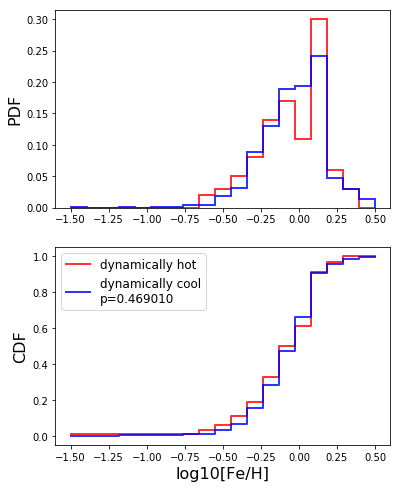

In [11]:
#show the difference of distribution of stellar properties for different stellar velocity.

#first stellar metallicity
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_host_feh,koi_cool_host_feh)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(-1.5,0.5,20)
weights1 = np.ones_like(koi_hot_host_feh)/float(len(koi_hot_host_feh))

ax1.hist(koi_hot_host_feh,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_host_feh)/float(len(koi_cool_host_feh))
ax1.hist(koi_cool_host_feh,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_host_feh)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_host_feh)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("log10[Fe/H]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/q2_feh.eps")

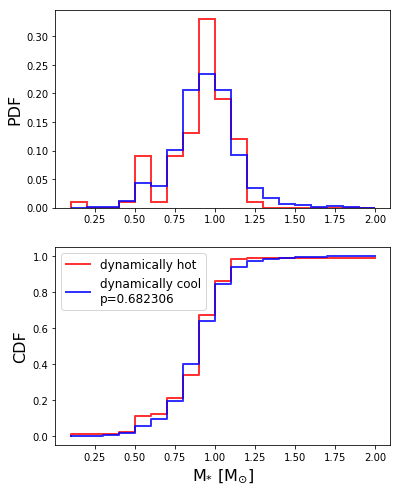

In [10]:
#show the difference of distribution of stellar properties for different stellar velocity.

#first stellar mass
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_host_mass,koi_cool_host_mass)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(0.1,2,20)
weights1 = np.ones_like(koi_hot_host_mass)/float(len(koi_hot_host_mass))

ax1.hist(koi_hot_host_mass,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_host_mass)/float(len(koi_cool_host_mass))
ax1.hist(koi_cool_host_mass,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xlim(0.1,0.7)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_host_mass)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_host_mass)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("M$_{*}$ [M$_{\odot}$]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/q2_mass.eps")

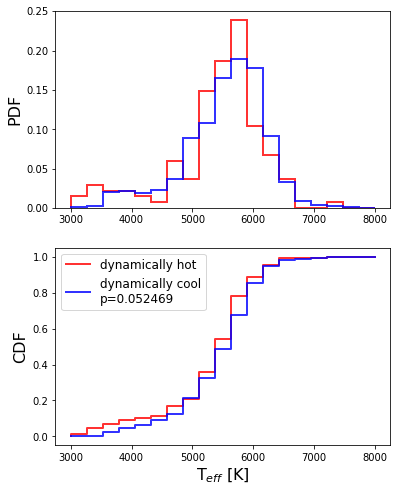

In [6]:
#show the difference of distribution of stellar properties for different stellar velocity.

#first stellar Teff
from scipy import stats
import statsmodels.api as sm
s1=stats.ks_2samp(koi_hot_host_teff,koi_cool_host_teff)
plt.figure(figsize=(6,8))
ax1=plt.subplot(2,1,1)
bins=np.linspace(3000,8000,20)
weights1 = np.ones_like(koi_hot_host_teff)/float(len(koi_hot_host_teff))

ax1.hist(koi_hot_host_teff,bins,histtype="step",weights=weights1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')

weights2 = np.ones_like(koi_cool_host_teff)/float(len(koi_cool_host_teff))
ax1.hist(koi_cool_host_teff,bins,histtype="step",weights=weights2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool')
#ax1.grid(True)
#plt.setp(ax15.get_xticklabels(), visible=False)
#ax1.legend(loc='best',fontsize=16)
ax1.set_ylabel("PDF",fontsize=16)
#ax1.set_xlim(0.1,0.7)
#ax1.set_xscale('log')
#ax1.set_xlim(1,1000)

ax2=plt.subplot(2,1,2)
ecdf=sm.distributions.ECDF(koi_hot_host_teff)
counts1=ecdf(bins)
ax2.step(bins,counts1,color='red',linewidth=2,alpha=0.8,label='dynamically hot')#
ecdf=sm.distributions.ECDF(koi_cool_host_teff)
counts2=ecdf(bins)
ax2.step(bins,counts2,color='blue',linewidth=2,alpha=0.8,label='dynamically cool'+'\n'+'p='+'{:5f}'.format(s1[1]))
ax2.set_xlabel("T$_{eff}$ [K]",fontsize=16)
ax2.set_ylabel("CDF",fontsize=16)
#ax2.set_xlim(1,1000)
ax2.legend(loc='best',fontsize=12)
#ax2.set_xscale('log')
plt.savefig("result/q2dot5_teff.eps")